# Homework 3 - Master's Degrees from all over!

Group 25:

Petra Udovicic: <petra.udovicic1997@gmail.com>, [GitHub](https://github.com/petraudovicic)

Dila Aslan: <dilaaslan0144@gmail.com>, [GitHub](https://github.com/dilaaslan3)

Edo Fejzic: <edo.fejzic@hotmail.com>, [GitHub](https://github.com/do3-173)

## 1. Data collection

### 1.1. Get the list of master's degree courses

Firstly, we need to create the `list_of_masters.py` module. 

In [ ]:
# Libraries
import requests
from bs4 import BeautifulSoup
import time
import os
from concurrent.futures import ThreadPoolExecutor
import pandas as pd

In [ ]:
BASE_URL = "https://www.findamasters.com/masters-degrees/msc-degrees/"
OUTPUT_FILE = "masters_urls.txt"

Checking out the URL and inspecting the website we find out the next piece of HTML code: `<a class="courseLink text-dark" href="/masters-degrees/course/applied-economics-banking-and-financial-markets-online-msc/?i280d8352c56675" title="Applied Economics (Banking and Financial Markets), online MSc at University of Bath Online, University of Bath"><u>Applied Economics (Banking and Financial Markets), online MSc</u></a>`. The class `courseLink text-dark` will be helpful for us in getting all the course links. 

In [ ]:
def get_course_urls(page_url):
    while True:
        try:
            response = requests.get(page_url, timeout=5)
            response.raise_for_status()
            break
        except requests.RequestException as e:
            # In case of failing request
            print(f"Request failed: {e}")
            time.sleep(1)
    soup = BeautifulSoup(response.content, "html.parser")
    course_links = soup.find_all("a", class_="courseLink text-dark")
    urls = [
        "https://www.findamasters.com" + link["href"]
        for link in course_links
        if "href" in link.attrs
    ]
    return urls

In [ ]:
for page in range(number_of_pages):
    # Progress bar
    if (page + 1) % 25 == 0 or page == 0:
        print(f"Scraping page {page + 1}")

    # String of page_url, in the first page only get the BASE_URL
    if page == 0:
        page_url = f"{BASE_URL}"
    else:
        page_url = f"{BASE_URL}?PG={page + 1}"
    urls = get_course_urls(page_url)

    if urls:
        # Append to the file so it remembers the previous entries
        with open(OUTPUT_FILE, "a") as file:
            for url in urls:
                file.write(f"{url}\n")

    # Sleeping to not have too many requests
    time.sleep(1)

After running the script, we need to check out the file, it should contain 6000 URLS.

In [ ]:
with open(OUTPUT_FILE, "r") as file:
    for count, line in enumerate(file):
        pass
# This needs to be 6000
print("Total Lines", count + 1)

Total Lines 6000


### 1.2. Crawl master's degree pages

For the second step, we need to download those HTML files and store them in the seperate folder. This will be done in the `crawler_master_html.py` module, below is the implementation.

In [ ]:
def download_html(url_and_folder):
    url, folder = url_and_folder
    while True:
        response = requests.get(url, timeout=5)
        # "Just a moment..." started showing up in some cases. 
        # Until we get the content we want continue trying the same URL
        if "Just a moment..." in response.text:
            time.sleep(1)
        else:
            filename = url.split("/")[-2] + url.split("/")[-1] + ".html"
            path = os.path.join(folder, filename)
            with open(path, "w") as file:
                file.write(response.text)
            time.sleep(1)
            break

After writing the `download_html` function, now we need to use it on all of the URLS that are present in masters_urls.txt file.

In [ ]:
with open("masters_urls.txt", "r") as file:
    urls = [url.strip() for url in file.readlines()]

url_and_folder_pairs = []
for i, url in enumerate(urls):
    page_number = i // 15 + 1
    folder = f"HTML/Page_{page_number}"
    os.makedirs(folder, exist_ok=True)
    url_and_folder_pairs.append((url, folder))

# Asynchronous execution of download_html at most 10 threads to save time
with ThreadPoolExecutor(max_workers=10) as executor:
    executor.map(download_html, url_and_folder_pairs)

Each of these HTML's will be downloaded in their respectful folder from where they came from. Asynchronous parallelism is being used for the function `download_html` to speed up the proces of crawling all the HTML's. 

### 1.3 Parse downloaded pages

For the final part, we need to parse downloaded HTML files. This will be done with the module `parser_html.py`. For all of the values of interest, we used Inspect Element in Firefox browser, to navigate to the correct HTML class that we need for data mining.

In [ ]:
def parse_html(html_content):
    soup = BeautifulSoup(html_content, "html.parser")

    course_name = (
        soup.find("h1", class_="course-header__course-title").text.strip()
        if soup.find("h1", class_="course-header__course-title")
        else ""
    )
    university_name = (
        soup.find("a", class_="course-header__institution").text.strip()
        if soup.find("a", class_="course-header__institution")
        else ""
    )
    faculty_name = (
        soup.find("a", class_="course-header__department").text.strip()
        if soup.find("a", class_="course-header__department")
        else ""
    )
    is_full_time = (
        soup.find("a", title="View all Full time Masters courses").text.strip()
        if soup.find("a", title="View all Full time Masters courses")
        else ""
    )
    description = (
        soup.find("div", id="Snippet").text.strip()
        if soup.find("div", id="Snippet")
        else ""
    )
    start_date = (
        soup.find("span", class_="key-info__start-date").text.strip()
        if soup.find("span", class_="key-info__start-date")
        else ""
    )
    fees = (
        soup.find("div", class_="course-sections__fees")
        .find("p")
        .get_text(separator=" ")
        .strip()
        if soup.find("div", class_="course-sections__fees")
        else ""
    )
    modality = (
        soup.find("span", class_="key-info__qualification").text.strip()
        if soup.find("span", class_="key-info__qualification")
        else ""
    )
    duration = (
        soup.find("span", class_="key-info__duration").text.strip()
        if soup.find("span", class_="key-info__duration")
        else ""
    )
    city = (
        soup.find("a", class_="course-data__city").text.strip()
        if soup.find("a", class_="course-data__city")
        else ""
    )
    country = (
        soup.find("a", class_="course-data__country").text.strip()
        if soup.find("a", class_="course-data__country")
        else ""
    )
    administration = (
        soup.find("a", class_="course-data__on-campus").text.strip()
        if soup.find("a", class_="course-data__on-campus")
        else ""
    )
    url = (
        soup.select_one('link[rel="canonical"]')["href"]
        if soup.select_one('link[rel="canonical"]')
        else ""
    )

    course_info = {
        "courseName": course_name,
        "universityName": university_name,
        "facultyName": faculty_name,
        "isItFullTime": is_full_time,
        "description": description,
        "startDate": start_date,
        "fees": fees,
        "modality": modality,
        "duration": duration,
        "city": city,
        "country": country,
        "administration": administration,
        "url": url,
    }

    return course_info

In [ ]:
def write_to_tsv(course_info, filename):
    with open("TSV/" + filename, "w", encoding="utf-8") as f:
        # First row we write the column names
        column_names = "\t".join(course_info.keys())
        f.write(column_names + "\n")    
        # Second row we write the values of columns
        column_values = "\t".join(str(value) for value in course_info.values())
        f.write(column_values + "\n")


After writing `parse_html` and `write_to_tsv`, now we need to write a script that will use it. We take all of the files inside `HTML` folder, parse them, and store them in seperate `.tsv` files that are named `course_{i}.tsv` where the `i` is the course number from 1 to 6000.

In [ ]:
root_path = "HTML/"

course_counter = 1
for root, dirs, files in os.walk(root_path):
    for file in files:
        if file.endswith(".html"):
            file_path = os.path.join(root, file)
            with open(file_path, "r", encoding="utf-8") as f:
                # Reading HTML
                html_content = f.read()

                # Parsing HTML
                course_info = parse_html(html_content)

                # " was giving us troubles so we removed it
                for key, value in course_info.items():
                    course_info[key] = value.replace('"', "")

                # Writing to the .tsv file
                tsv_filename = f"course_{course_counter}.tsv"
                write_to_tsv(course_info, tsv_filename)

                course_counter += 1

Now we need to test the dataset, if we managed to complete the task successfully.

In [ ]:
# Read the TSV data
df = pd.read_csv("TSV/course_1.tsv", sep="\t", index_col=False)

for i in range(2, 6001):
    try:
        df1 = pd.read_csv("TSV/course_" + str(i) + ".tsv", sep="\t", index_col=False)
        df1.index += i - 1
        df = pd.concat([df, df1])
    except Exception as e:
        print(i)
        print("Error: ", e)

df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Computer Science - MSc,University of Hertfordshire,"School of Physics, Engineering and Computer Sc...",Full time,Why choose Herts?Industry Accreditation: Accre...,See Course,UK Students Full time: £9450 for the 2022/202...,MSc,"1 year full-time, 15 months full-time, 3 years...",Hatfield,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
1,Computer Science (Cyber Security) - MSc,Staffordshire University,"School of Digital, Technologies and Arts",Full time,Join the fight against malicious programs and ...,September,Find the specific fees for your chosen program...,MSc,13 months - 25 months,Stoke on Trent,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
2,Computer Science (Data Science) - MSc,Trinity College Dublin,School of Computer Science & Statistics,Full time,The MSc in Computer Science is an exciting one...,September,Please see the university website for further ...,MSc,1 year full-time,Dublin,Ireland,On Campus,https://www.findamasters.com/masters-degrees/c...
3,Computer Science (by Research) - MSc,Lancaster University,School of Computing and Communications,Full time,The MSc by Research programme can be tailored ...,See Course,Please see the university website for further ...,MSc,"12 months full-time, 24 months part time",Lancaster,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
4,Computer Science (Computer Networks and Securi...,Staffordshire University,"School of Digital, Technologies and Arts",Full time,Secure your future career with our Computer Sc...,September,Find the specific fees for your chosen program...,MSc,13 months - 25 months,Stoke on Trent,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   courseName      5975 non-null   object
 1   universityName  5975 non-null   object
 2   facultyName     5975 non-null   object
 3   isItFullTime    5250 non-null   object
 4   description     5975 non-null   object
 5   startDate       5975 non-null   object
 6   fees            5854 non-null   object
 7   modality        5975 non-null   object
 8   duration        5975 non-null   object
 9   city            5975 non-null   object
 10  country         5975 non-null   object
 11  administration  5199 non-null   object
 12  url             5979 non-null   object
dtypes: object(13)
memory usage: 609.5+ KB


In [ ]:
df[df['courseName'].isnull()]

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
1083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2459,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that we have 25 bad entries in the dataset examining the NaN courseName entries. Examining the .tsv files with these index it appears that they are mostly empty. Furthermore, going into the HTML files we see that all 25 URL's are broken.

## 2. Search Engine

In [1]:
# Libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import string
import re
from collections import Counter
from functools import reduce
import json
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK Download
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /home/edo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/edo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Read the TSV data
df = pd.read_csv("TSV/course_1.tsv", sep="\t", index_col=False)

for i in range(2, 6001):
    try:
        df1 = pd.read_csv(
            "TSV/course_" + str(i) + ".tsv",
            sep="\t",
            index_col=False,
        )
        df1.index += i - 1
        df = pd.concat([df, df1])
    except Exception as e:
        print(i)
        print("Error: ", e)

df.head()

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Computer Science - MSc,University of Hertfordshire,"School of Physics, Engineering and Computer Sc...",Full time,Why choose Herts?Industry Accreditation: Accre...,See Course,UK Students Full time: £9450 for the 2022/202...,MSc,"1 year full-time, 15 months full-time, 3 years...",Hatfield,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
1,Computer Science (Cyber Security) - MSc,Staffordshire University,"School of Digital, Technologies and Arts",Full time,Join the fight against malicious programs and ...,September,Find the specific fees for your chosen program...,MSc,13 months - 25 months,Stoke on Trent,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
2,Computer Science (Data Science) - MSc,Trinity College Dublin,School of Computer Science & Statistics,Full time,The MSc in Computer Science is an exciting one...,September,Please see the university website for further ...,MSc,1 year full-time,Dublin,Ireland,On Campus,https://www.findamasters.com/masters-degrees/c...
3,Computer Science (by Research) - MSc,Lancaster University,School of Computing and Communications,Full time,The MSc by Research programme can be tailored ...,See Course,Please see the university website for further ...,MSc,"12 months full-time, 24 months part time",Lancaster,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...
4,Computer Science (Computer Networks and Securi...,Staffordshire University,"School of Digital, Technologies and Arts",Full time,Secure your future career with our Computer Sc...,September,Find the specific fees for your chosen program...,MSc,13 months - 25 months,Stoke on Trent,United Kingdom,On Campus,https://www.findamasters.com/masters-degrees/c...


As we can see from examining the dataset in question 1, there seems to be some NaN rows that need to be dealt with. We will firstly drop them, and all NaN values that remain will be made into empty strings.

In [4]:
df = df.dropna(subset=['courseName'])
df = df.replace(np.nan, '')

# This needs to be an empty dataframe
df[df['courseName'].isnull()]

,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url


Now we need to preprocess dataset, it will be done in seperate dataframe to keep the original one for results. Firstly, we will remove stopwords:

In [7]:
def stopless(text):
    # Checking if the instance is string, there were some problems with int/float values
    if isinstance(text, str):
        words = word_tokenize(text)
        stop_words = set(stopwords.words("english"))
        filtered_words = [word for word in words if word.lower() not in stop_words]
        return " ".join(filtered_words)
    else:
        return text

In [8]:
df_preprocessed = df.applymap(stopless)
df_preprocessed.head()

/tmp/ipykernel_20114/3404425599.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_preprocessed = df.applymap(stopless)


,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Computer Science - MSc,University Hertfordshire,"School Physics , Engineering Computer Science",Full time,choose Herts ? Industry Accreditation : Accred...,See Course,UK Students Full time : £9450 2022/2023 academ...,MSc,"1 year full-time , 15 months full-time , 3 yea...",Hatfield,United Kingdom,Campus,https : //www.findamasters.com/masters-degrees...
1,Computer Science ( Cyber Security ) - MSc,Staffordshire University,"School Digital , Technologies Arts",Full time,Join fight malicious programs cybercrime Compu...,September,Find specific fees chosen programme website,MSc,13 months - 25 months,Stoke Trent,United Kingdom,Campus,https : //www.findamasters.com/masters-degrees...
2,Computer Science ( Data Science ) - MSc,Trinity College Dublin,School Computer Science & Statistics,Full time,MSc Computer Science exciting one-calendar-yea...,September,Please see university website information fees...,MSc,1 year full-time,Dublin,Ireland,Campus,https : //www.findamasters.com/masters-degrees...
3,Computer Science ( Research ) - MSc,Lancaster University,School Computing Communications,Full time,MSc Research programme tailored individual res...,See Course,Please see university website information fees...,MSc,"12 months full-time , 24 months part time",Lancaster,United Kingdom,Campus,https : //www.findamasters.com/masters-degrees...
4,Computer Science ( Computer Networks Security ...,Staffordshire University,"School Digital , Technologies Arts",Full time,Secure future career Computer Science ( Comput...,September,Find specific fees chosen programme website,MSc,13 months - 25 months,Stoke Trent,United Kingdom,Campus,https : //www.findamasters.com/masters-degrees...


Now, we need to remove punctuation:

In [9]:
def punct(text):
    # Checking if the instance is string, there were some problems with int/float values
    if isinstance(text, str):
        words = word_tokenize(text)
        filtered_words = [
            word for word in words if word.lower() not in string.punctuation
        ]
        return " ".join(filtered_words)
    else:
        return text

In [10]:
df_preprocessed = df_preprocessed.applymap(punct)
df_preprocessed.head()

/tmp/ipykernel_20114/3437730669.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_preprocessed = df_preprocessed.applymap(punct)


,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,Computer Science MSc,University Hertfordshire,School Physics Engineering Computer Science,Full time,choose Herts Industry Accreditation Accredited...,See Course,UK Students Full time £9450 2022/2023 academic...,MSc,1 year full-time 15 months full-time 3 years p...,Hatfield,United Kingdom,Campus,https //www.findamasters.com/masters-degrees/c...
1,Computer Science Cyber Security MSc,Staffordshire University,School Digital Technologies Arts,Full time,Join fight malicious programs cybercrime Compu...,September,Find specific fees chosen programme website,MSc,13 months 25 months,Stoke Trent,United Kingdom,Campus,https //www.findamasters.com/masters-degrees/c...
2,Computer Science Data Science MSc,Trinity College Dublin,School Computer Science Statistics,Full time,MSc Computer Science exciting one-calendar-yea...,September,Please see university website information fees...,MSc,1 year full-time,Dublin,Ireland,Campus,https //www.findamasters.com/masters-degrees/c...
3,Computer Science Research MSc,Lancaster University,School Computing Communications,Full time,MSc Research programme tailored individual res...,See Course,Please see university website information fees...,MSc,12 months full-time 24 months part time,Lancaster,United Kingdom,Campus,https //www.findamasters.com/masters-degrees/c...
4,Computer Science Computer Networks Security MSc,Staffordshire University,School Digital Technologies Arts,Full time,Secure future career Computer Science Computer...,September,Find specific fees chosen programme website,MSc,13 months 25 months,Stoke Trent,United Kingdom,Campus,https //www.findamasters.com/masters-degrees/c...


Stemming:

In [ ]:
def stem(text):
    if isinstance(text, str):
        ps = PorterStemmer()
        words = word_tokenize(text)
        stemmed_words = [ps.stem(word) for word in words]
        return " ".join(stemmed_words)
    else:
        return text

In [ ]:
df_preprocessed = df_preprocessed.applymap(stem)
df_preprocessed.head()

/tmp/ipykernel_3522/3393340246.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_preprocessed = df_preprocessed.applymap(stem)


,courseName,universityName,facultyName,isItFullTime,description,startDate,fees,modality,duration,city,country,administration,url
0,comput scienc msc,univers hertfordshir,school physic engin comput scienc,full time,choos hert industri accredit accredit british ...,see cours,uk student full time £9450 2022/2023 academ ye...,msc,1 year full-tim 15 month full-tim 3 year part-tim,hatfield,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...
1,comput scienc cyber secur msc,staffordshir univers,school digit technolog art,full time,join fight malici program cybercrim comput sci...,septemb,find specif fee chosen programm websit,msc,13 month 25 month,stoke trent,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...
2,comput scienc data scienc msc,triniti colleg dublin,school comput scienc statist,full time,msc comput scienc excit one-calendar-year prog...,septemb,pleas see univers websit inform fee cours,msc,1 year full-tim,dublin,ireland,campu,http //www.findamasters.com/masters-degrees/co...
3,comput scienc research msc,lancast univers,school comput commun,full time,msc research programm tailor individu research...,see cours,pleas see univers websit inform fee cours,msc,12 month full-tim 24 month part time,lancast,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...
4,comput scienc comput network secur msc,staffordshir univers,school digit technolog art,full time,secur futur career comput scienc comput networ...,septemb,find specif fee chosen programm websit,msc,13 month 25 month,stoke trent,unit kingdom,campu,http //www.findamasters.com/masters-degrees/co...


## 3. Define a new score!

## 4. Visualizing the most relevant MSc degrees

## 5. BONUS: More complex search engine 

## 6. Command Line Question

### **1. Command Line Script Analysis**


All scripts will be contained within `CommandLine.sh`, which is used for analyzing the scripts.

Firstly, let's write a script to merge all our courses into a single `.tsv` file. We will write the contents of the first course into `merged_courses.tsv`. This action is performed outside the for loop with two considerations in mind:

1. If a `merged_courses.tsv` file already exists, it will be overwritten with the new file containing only the contents of `course_1.tsv`.
2. At the top of the file, we need the names of the columns. Since every file's first line contains these column names, we use the `tail` command within the for loop to extract the last two lines of each `courses_i.tsv` file. Extracting two lines is necessary because there is always a newline character at the end of each `courses_i.tsv` file, and we also need to include the line containing the content.


In [ ]:
%%bash
cat TSV/course_1.tsv > merged_courses.tsv
for i in {2..6000}
do
   tail +2 TSV/course_${i}.tsv >> merged_courses.tsv
done

For the first part, we need to identify the country and city that offer the most Master's Degrees. The process is similar for both, differing only in the column used. 

Firstly, we use `echo` to display "Country: " or "City: ", ensuring we do not echo a trailing newline. Then, `cut` is employed to extract the required column. We sort this column, and then use `uniq` with the `-c` option to count unique entries. Next, we sort these counts in reverse order (`sort -nr`), so the country or city with the highest number of Master's courses appears at the top. 

Since we're interested only in the first entry, which has the highest count, we use `head -1` to retrieve it. Finally, for better formatting and readability, `awk` is used to process and display the output.


In [ ]:
%%bash  
echo -n "Country that offers most Master's Degrees: "
cut -f11 merged_courses.tsv | sort | uniq -c | sort -nr | head -1 | awk '{print substr($0, index($0,$2)) ", number of occurrences: " $1}'
echo -n "City that offers most Master's Degrees: "
cut -f10 merged_courses.tsv | sort | uniq -c | sort -nr | head -1 | awk '{print substr($0, index($0,$2)) ", number of occurrences: " $1}'

Country that offers most Master's Degrees: United Kingdom, number of occurrences: 4485
City that offers most Master's Degrees: London, number of occurrences: 1085


Now, we need to identify all universities that offer part-time courses. To do this, we will use `awk` to search through all courses. We'll employ a regular expression to match entries with `part time` or `part-time`. Our focus is on the universities listed in column 2, so we'll extract these.

Next, we sort these university names and then use `uniq` to filter out duplicates, thereby compiling a list that represents the number of unique courses offered. Finally, we count the number of universities in this list and store this figure in the `part_time` variable.

In [ ]:
%%bash
part_time=$(awk -F'\t' 'tolower($0) ~ /part[- ]time/ {print $2}' merged_courses.tsv | sort | uniq | wc -l)
echo "Number of universities that offer part-time courses: ${part_time}"

Number of universities that offer part-time courses: 153


For our final task, we will work with two variables. The first one, `total_courses`, calculates the total number of courses in the dataset. Importantly, it excludes the header row and any lines that have no values. The second variable, `engineering_courses`, counts all courses containing the term `engineer` in their course name.

We then calculate the percentage of engineering courses, accurate to two decimal places. Finally, we echo the calculated percentage to display the result. Below the script is the screenshot of `CommandLine.sh` running in terminal.

In [ ]:
%%bash
total_courses=$(awk -F'\t' 'NR > 1 && $1 != ""' merged_courses.tsv | wc -l)
engineering_courses=$(awk -F '\t' 'tolower($1) ~ /engineer/' merged_courses.tsv | wc -l)
percentage=$(echo "scale=2; $engineering_courses * 100 / $total_courses" | bc)
echo "Percentage of engineering courses: $percentage%"

Percentage of engineering courses: 10.32%


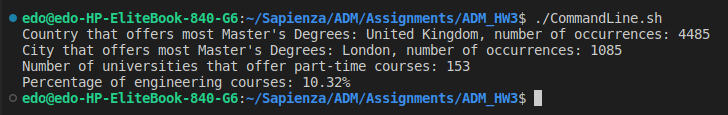

## 7. Algorithmic Question 

### 1. Implement a code to solve the above mentioned problem. 

Let's implement the function that will give us optimal hours for Leonardo. if there is no way to create a report return `None`. 

In [ ]:
def optimal_hours(min_max_hours_array, sum_hours):
    sum_min_hours, sum_max_hours = map(sum, zip(*min_max_hours_array))

    # If the sum_hours is not in this range, then we can't create a report
    if sum_min_hours <= sum_hours <= sum_max_hours:
        # Each day we work at least min hours
        optimal_hours_array = [x[0] for x in min_max_hours_array]

        # Rest of the hours that we have to add
        temp_sum_hours = sum_hours - sum_min_hours

        for i in range(len(min_max_hours_array)):
            available_hours = min_max_hours_array[i][1] - optimal_hours_array[i]
            additional_hours = min(available_hours, temp_sum_hours)

            optimal_hours_array[i] += additional_hours
            temp_sum_hours -= additional_hours

            # If we managed to reduce hours to 0, there are no hours left to be allocated anymore
            if temp_sum_hours == 0:
                break

        # Checking if the optimal_hours_array report is correct
        if sum(optimal_hours_array) == sum_hours:
            return optimal_hours_array
        else:
            return None
    else:
        return None

Testing the function:

In [ ]:
def test_optimal_hours(test_case):
    min_max_hours_array = test_case[0]
    sum_hours = test_case[1]

    optimal_hours_array = optimal_hours(min_max_hours_array, sum_hours)
    if optimal_hours_array:
        print("YES")
        for hours in optimal_hours_array:
            print(hours, end=" ")
    else:
        print("NO")

In [ ]:
test_case_1 = [[[0, 1], [3, 5]], 5]
test_case_2 = [[[5, 6]], 1]

In [ ]:
test_optimal_hours(test_case_1)

YES
1 4 

In [ ]:
test_optimal_hours(test_case_2)

NO


Below is the code that takes the input from console that can be used for testing:

In [ ]:
d, sum_hours = map(int, input().split())

min_max_hours_array = []

for _ in range(d):
    min_hours, max_hours = map(int, input().split())
    min_max_hours_array.append([min_hours, max_hours])

test_optimal_hours([min_max_hours_array, sum_hours])

YES
1 4 

Looking at the results, we can see that the input matches the output. 

### 2. What is the __time complexity__ (the Big O notation) of your solution? Please provide a <ins>detailed explanation</ins> of how you calculated the time complexity.

Let's look at the function `optimal_hours(min_max_hours_array, sum_hours)` because it is used for giving us the solution, we will not take the input into consideration:

In [ ]:
# sum_min_hours, sum_max_hours = map(sum, zip(*min_max_hours_array))

This part of the code is `O(n)`,beacuse we iterate all of the hours once to find the sum of the min and max hours that are needed to work.

In [ ]:
# if sum_min_hours <= sum_hours <= sum_max_hours:
#     optimal_hours_array = [x[0] for x in min_max_hours_array]
#     temp_sum_hours = sum_hours - sum_min_hours

# else:
#     return None

Above we have if statement which is `O(1)` and below that we have `O(n)`,because we go through the array once again. Subtraction between sum of hours worked and minimum required is O(1). Else is same as if, O(1).

In [ ]:
# for i in range(len(min_max_hours_array)):
#         available_hours = min_max_hours_array[i][1] - optimal_hours_array[i]
#         additional_hours = min(available_hours, temp_sum_hours)

#         optimal_hours_array[i] += additional_hours
#         temp_sum_hours -= additional_hours

#         if temp_sum_hours == 0:
#             break

Now, we have a for loop that goes through each element once; in the worst-case scenario, it is `O(n)` if the solution is not found by the end of the `min_max_hours_array`. All of the calculations inside are `O(1)`, so the final complexity of this for loop is `O(n)`.

In [ ]:
# if sum(optimal_hours_array) == sum_hours:
#     return optimal_hours_array
# else:
#     return None

Finally, we look at the optimal hours, `optimal_hours_array` has size the same as `min_max_hours_array`, so finding the sum of all elements is `O(n)`,and if-else statement is `O(1)`.

After analyzing all of the code we get that the final Big-O notation complexity of the code is `O(n)`. 

### 3. Ask ChatGPT or any other LLM chatbot tool to check your code's time complexity (the Big O notation). 

The prompt used for asking about the code's time complexity is next:

`can you check the time complexity big o notation of this code: (code of function optimal_hours)`

This is the output:

The provided Python function `optimal_hours` calculates an array of 'optimal hours' based on a given array of minimum and maximum hours for each day and a target sum of hours. Below is the time complexity analysis of the code:

1. **Calculating the sums of minimum and maximum hours:**
   - `sum_min_hours, sum_max_hours = map(sum, zip(*min_max_hours_array))`
   This operation runs in `O(n)` time, where `n` is the length of `min_max_hours_array`, since the `sum` and `zip` functions both run in linear time.

2. **Bounds checking for the target sum of hours:**
   - `if sum_min_hours <= sum_hours <= sum_max_hours:`
   This is a constant-time operation, `O(1)`.

3. **Initialization of the optimal hours array:**
   - `optimal_hours_array = [x[0] for x in min_max_hours_array]`
   This list comprehension also runs in `O(n)` time.

4. **Main loop for calculating optimal hours:**
   - `for i in range(len(min_max_hours_array)):`
   The loop itself has a worst-case scenario of `O(n)`.

   Inside the loop, all operations (calculating `available_hours`, `additional_hours`, updating `optimal_hours_array[i]`, and decrementing `temp_sum_hours`) are constant-time operations, `O(1)`.

5. **Final sum check:**
   - `if sum(optimal_hours_array) == sum_hours:`
   This is another `O(n)` operation.

Considering all the above points, the overall time complexity of this function is the sum of the individual complexities. However, since all these operations are sequential and the loop is the most significant portion, the overall time complexity is dominated by the loop and simplifies to `O(n)`. Therefore, the final Big O notation for the function is `O(n)`.

As we can see, and checking with our result, we also got the `O(n)` time complexity for the function `optimal_hours`. We believe it is correct and both calculations are right.

### 4. What do you think of the __optimality__ of your code? Do you believe it is optimal? Can you improve?

Given that the code has a time complexity of `O(n)`, it is quite optimal. However, it can be observed that there are a number of `O(n)` operations being executed, so improvements could be made by combining some for loops. Additionally, the code does not validate the data, which could lead to problems, especially if there are large arrays that are memory-intensive.